## SHIVAM MISHRA 
### HOMEWORK 3 ENPM 808W

In [70]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/umd-enpm808w-hw3/qb.test.csv
/kaggle/input/umd-enpm808w-hw3/feature_expansion.R
/kaggle/input/umd-enpm808w-hw3/qb.train.csv


In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [72]:
# LOADING TRAINING DATA
df = pd.read_csv('../input/umd-enpm808w-hw3/qb.train.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8079 entries, 0 to 8078
Data columns (total 10 columns):
row            8079 non-null int64
body_score     8079 non-null float64
page           8079 non-null object
answer         8079 non-null object
text           8079 non-null object
category       8079 non-null object
tournaments    8079 non-null object
answer_type    8079 non-null object
corr           8079 non-null bool
inlinks        8079 non-null int64
dtypes: bool(1), float64(1), int64(2), object(6)
memory usage: 576.1+ KB


df.info() indicates that all the rows of the training data is filled. There is no instance of missing data. To build the classifier some of these features are going to be used directly, and some will be used indirectly.

The features which are created from the features are shown below.

def bracket function checks the presence of bracket in the "page" data-feature. if "()" is present in the page data-feature, the value is True else the value is False.
This text inside the bracket in "page" data-feature denotes the existence of more than one pages with same name. The text inside the bracket categorises it.

the presence of "()" denotes that more than one pages with the same name exists. the added data feature for the same in the data-frame is "is_bracket". It would be interesting feature to add the text inside the paranthesis of the "page" data-feature in the data-frame, but that is not done here.

the "is_bracket" data-feature is generates using "is_bracket" function which is defined below.

In [73]:
def is_bracket(temp_string):
    if "(" in temp_string:
        return 1
    else:
        return 0

df['is_bracket'] = df['page']
df['is_bracket'] = df['is_bracket'].apply(lambda x: is_bracket(x))

Inlinks refer to the number of links inside the guess page. This feature is actually a measure of the page's popularity. It intitionally shouldn't help much for the classification problem. Let's see this through a plot distinguishing how "right" and "wrong" answer varies with respect to "inlinks" there pages have.

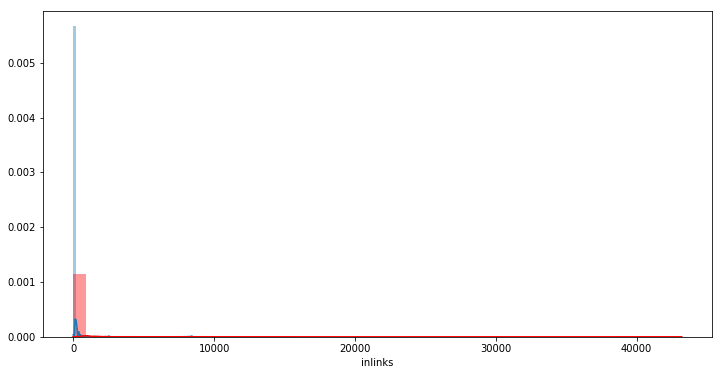

In [84]:
df_true = df[df['corr']==True]
df_false = df[df['corr']== False]
plt.figure(figsize = (12,6))
sns.distplot(df_true['inlinks'])
sns.distplot(df_false['inlinks'],color = 'r')

In [85]:
def log_inlinks(inlink):
    if inlink == 0:
        return 100
    else:
        return np.log(inlink)
    
df['log_inlinks'] = df['inlinks'].apply(lambda x: log_inlinks(x))

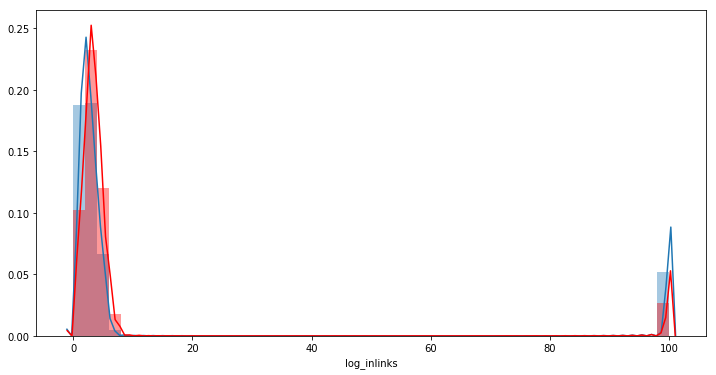

In [86]:
df_true = df[df['corr']==True]
df_false = df[df['corr']== False]

plt.figure(figsize = (12,6))
sns.distplot(df_true['log_inlinks'])
sns.distplot(df_false['log_inlinks'],color = 'r')

As can be seen in the graph above, the inlink feature which even can't be visaulised clearly (due to the high range in its values) isn't a great feature for classification of wrong and right answers.

then again, to better visaulize and see if there is any way one can get better results, log value of inlink value is taken. Even after taking the log of the value, the distinguishing feature of the two classes doesn't improve much.

In [87]:
df['answer_type'].value_counts()

people    3051
work      2895
None      1617
char       293
place       71
org         68
abs         46
event       19
anim        19
Name: answer_type, dtype: int64

the answer type contains a great number of "people" answer type. In the next two features are extracted. 
One is the length of the "text" in the data-set. The length of "text" in the data-set denotes that after how much of text the correct answer was answered. My intuition is that for right answers the average number of words in the text must be greater than the wrong answer, or in other words greater the text revealed greater is the probability of correct answer.

the second feature type, generated is if the pronoun is present in the text or not. The intuition behind this feature is that, for the answer type "people" (which is a huge chunk of this data-set) the text must contain pronouns as per the standard rules of the english language. They may also be available for the other answer types but i believe presence of pronouns in the text can play a significant role to determine the correct answer for "people" answer type. 
#### [Answer of the 3rd question. Not highlighting anywhere else, its inclusive in the next few lines of code and markdowns]

This feature is generated using nltk module. using word_tokenize the text is broken into words and the count of pronouns in the data-set is stored in "pronoun_count" feature. Similiarly, the length of the text is stored as "text_length" feature in the data-set.

In [88]:
from nltk.tokenize import sent_tokenize, word_tokenize

def count_pronoun_len(temp_text):
    temp_word_array = word_tokenize(temp_text)
    text_length = len(temp_word_array)
    pronoun_list = ['his','her','him','His','Her','Him']
    pronoun_count = 0
    for word in temp_word_array:
        if word in pronoun_list:
            pronoun_count = pronoun_count + 1
    return pronoun_count,text_length

df['pronoun_count'] = df['text'].apply(lambda x: count_pronoun_len(x)[0])
df['text_length'] = df['text'].apply(lambda x: count_pronoun_len(x)[1])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


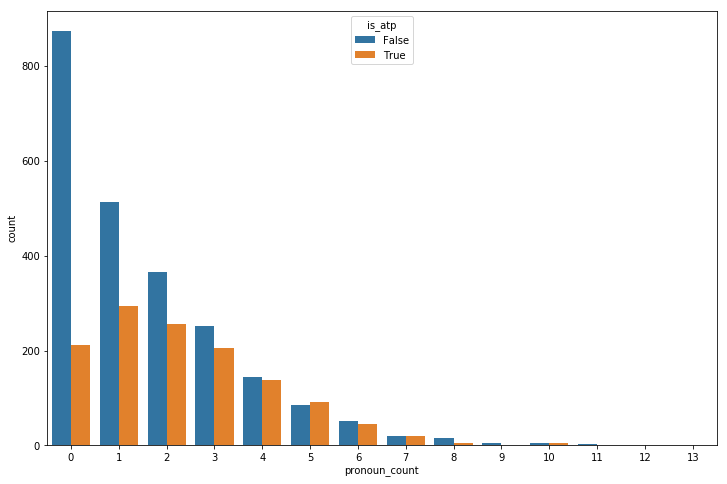

In [98]:
df_true = df[df['corr'] == True]

def is_answer_type_people(answer_type):  # is_atp feature value in dataframe
    if answer_type == 'people':
        return True
    else:
        return False
    
df_true['is_atp'] = df_true['answer_type'].apply(lambda x: is_answer_type_people(x))
df['is_atp'] = df['answer_type'].apply(lambda x: is_answer_type_people(x))

plt.figure(figsize=(12,8))
sns.countplot(x = 'pronoun_count',hue = 'is_atp',data = df_true)
plt.show()

the above function distinguishes bewtween the answer_type = people and answer_type = others by creating a new feature in the dataframe named "is_atp" which is true if answer type is people and is False if the answer type is something other than people. [PLOT IS ONLY FOR "CORRECT OR TRUE" ANSWERS]

This graph shows that a great number of true answers of "OTHER" answer type do not have pronouns in them. the pie plot below shows that almost 80 percent of the "TRUE" answers in answer_type = "PEOPLE" category contains pronoun. 

This both points out to the fact that a feature deciding if the PRONOUNS are present in the text or not is worthwhile.

In [99]:
df_true_people = df_true[df_true['answer_type'] == 'people']

def is_pronoun (pronoun_count):
    if pronoun_count == 0:
        return 0
    else:
        return 1
df_true_people['is_pronoun'] = df_true_people['pronoun_count'].apply(lambda x : is_pronoun(x))

df_true_people['is_pronoun'].value_counts()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


1    1060
0     212
Name: is_pronoun, dtype: int64

<Figure size 504x504 with 0 Axes>

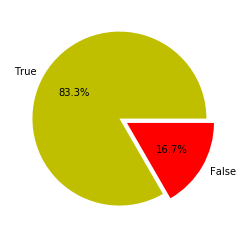

In [100]:
plt.figure(figsize = (7,7))
fig, ax = plt.subplots(1,1)
ax.pie(df_true_people.is_pronoun.value_counts(),explode=(0,0.1), autopct='%1.1f%%', labels = ['True', 'False'], colors=['y','r'])
plt.axis = 'equal'

the IS_PRONOUN function categorizes the cases of the text where pronoun is present or not. It is 0 if pronoun count in text is zero and is 1 if it's not zero.

#### note: commonly occuring pronoun for the people, like "his", "him" and "her" is only considered here.

In [101]:
df['is_pronoun'] = df['pronoun_count'].apply(lambda x : is_pronoun(x))

Move to the prediction stage.

In [102]:
df1 = df[['body_score','tournaments','answer_type','inlinks','is_bracket','log_inlinks','pronoun_count','text_length','is_pronoun','is_atp','corr']]
df1 = pd.get_dummies(df1,columns = ['answer_type','tournaments'])

In [103]:
X = df1.drop(columns = ['corr']).values
y = df1['corr'].values

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_true = y_test

## Logistic Regression

In [104]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_true = y_test

LR_solvers = ['newton-cg', 'lbfgs', 'liblinear','sag', 'saga']

for solver in LR_solvers:
    from sklearn.linear_model import LogisticRegression
    LR_clf = LogisticRegression(random_state=48, solver = solver, max_iter = 1000).fit(X_train, y_train)
    y_pred = LR_clf.predict(X_test)
    
    temp_accuracy = accuracy_score(y_true, y_pred)
    print('Logistic Regression accuracy with solver ' + solver+" >>",temp_accuracy)

Logistic Regression accuracy with solver newton-cg >> 0.7085396039603961


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Logistic Regression accuracy with solver lbfgs >> 0.7085396039603961
Logistic Regression accuracy with solver liblinear >> 0.7091584158415841


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Logistic Regression accuracy with solver sag >> 0.6336633663366337
Logistic Regression accuracy with solver saga >> 0.6386138613861386


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


The logistic regression is not working well. It's not even converging for some of the cases even though the max_iter value is set to 1000. This is possibly due to the large number of data-features in the data-set. Eliminating redundant and unncessary data-set is possibly going to help the Logistic regression to converge.

The features "tournaments" and "answer_type" should be let away with. they mainly contribute to the generation of large number of feature in the data-frame.

also ditching "sag" and "saga" solvers. both performed very badly above and had problems converging.

In [106]:
df2 = df[['body_score','is_bracket','log_inlinks','text_length','is_pronoun','is_atp','corr']]

X = df2.drop(columns = ['corr']).values
y = df2['corr'].values

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_true = y_test

LR_solvers = ['newton-cg', 'lbfgs', 'liblinear']

for solver in LR_solvers:
    from sklearn.linear_model import LogisticRegression
    LR_clf = LogisticRegression(random_state=48, solver = solver, max_iter = 1000).fit(X_train, y_train)
    y_pred = LR_clf.predict(X_test)
    
    temp_accuracy = accuracy_score(y_true, y_pred)
    print('Logistic Regression accuracy with solver ' + solver+" >>",temp_accuracy)

Logistic Regression accuracy with solver newton-cg >> 0.7029702970297029
Logistic Regression accuracy with solver lbfgs >> 0.7029702970297029
Logistic Regression accuracy with solver liblinear >> 0.7029702970297029


#### The results from all the solver of the logistic regression is almost equal. And the LR accuracy score is close to 0.7.

## DECISION TREES

In [107]:
DT_criteria = ['gini','entropy']

for criteria in DT_criteria:
    from sklearn.tree import DecisionTreeClassifier
    DT_clf = DecisionTreeClassifier(criterion = criteria, max_depth = 8, random_state = 28)
    DT_clf.fit(X_train, y_train)
    y_pred = DT_clf.predict(X_test)
    
    temp_accuracy = accuracy_score(y_true, y_pred)
    print('DTC accuracy with criterion ' + criteria +" >>",temp_accuracy)

DTC accuracy with criterion gini >> 0.7926980198019802
DTC accuracy with criterion entropy >> 0.7995049504950495


#### For both the decision tree criteria we have almost equal accuracy of 0.8. 

## RANDOM FORREST CLASSIFIER

In [108]:
# VARYING THE NUMBER OF ESTIMATORS OR THE NUMBER OF DECISION TREES IN THE FORREST
for i in range(10,400,10):
    from sklearn.ensemble import RandomForestClassifier
    RFC_clf = RandomForestClassifier(n_estimators=i, max_depth=13,random_state=28)
    RFC_clf.fit(X_train, y_train)
    y_pred = RFC_clf.predict(X_test)
    temp_accuracy = accuracy_score(y_true, y_pred)
    
    print(i,temp_accuracy)

10 0.8254950495049505
20 0.8329207920792079
30 0.8273514851485149
40 0.8298267326732673
50 0.8298267326732673
60 0.8267326732673267
70 0.8236386138613861
80 0.8217821782178217
90 0.8267326732673267
100 0.8267326732673267
110 0.8254950495049505
120 0.8267326732673267
130 0.8267326732673267
140 0.8273514851485149
150 0.8273514851485149
160 0.8285891089108911
170 0.8267326732673267
180 0.8267326732673267
190 0.8273514851485149
200 0.8267326732673267
210 0.8254950495049505
220 0.8273514851485149
230 0.8254950495049505
240 0.8254950495049505
250 0.8261138613861386
260 0.8261138613861386
270 0.8248762376237624
280 0.8261138613861386
290 0.8254950495049505
300 0.8267326732673267
310 0.8254950495049505
320 0.8248762376237624
330 0.8254950495049505
340 0.8242574257425742
350 0.8254950495049505
360 0.8254950495049505
370 0.8254950495049505
380 0.8261138613861386
390 0.8242574257425742


In [109]:
for i in range(3,25):
    from sklearn.ensemble import RandomForestClassifier
    RFC_clf = RandomForestClassifier(n_estimators=50, max_depth=i,random_state=28)
    RFC_clf.fit(X_train, y_train)
    y_pred = RFC_clf.predict(X_test)
    temp_accuracy = accuracy_score(y_true, y_pred)
    
    print(i,temp_accuracy)

3 0.7599009900990099
4 0.7660891089108911
5 0.7778465346534653
6 0.7846534653465347
7 0.801980198019802
8 0.8056930693069307
9 0.8143564356435643
10 0.8217821782178217
11 0.8248762376237624
12 0.8224009900990099
13 0.8298267326732673
14 0.8273514851485149
15 0.8279702970297029
16 0.8193069306930693
17 0.8248762376237624
18 0.8168316831683168
19 0.8199257425742574
20 0.8193069306930693
21 0.8149752475247525
22 0.8125
23 0.8162128712871287
24 0.8162128712871287


The accuracy is maximum for a max_depth = 13 value and number of decision trees = 50 value. choosing a max_depth of 13 and number of trees equal to 50 for the random forrest classifer.

In [111]:
RFC_clf = RandomForestClassifier(n_estimators=50, max_depth=13,random_state=28)
RFC_clf.fit(X_train, y_train)
y_pred = RFC_clf.predict(X_test)
temp_accuracy = accuracy_score(y_true, y_pred)
print('The accuracy score for random forrest classifier is >> ', temp_accuracy)

The accuracy score for random forrest classifier is >>  0.8298267326732673


#### The accuracy is coming out to be close to 0.83...maximum till now.

## SUPPORT VECTOR CLASSIFIER

In [114]:
from sklearn import linear_model
SVM_clf = linear_model.SGDClassifier(max_iter=1000, tol=1e-3)  

# USING THIS AS THE DATA-SET IS CONSIDERABLY LARGE. THIS IMPLEMENTS
# SVM AFTER SGD TRAINING. MY COMPUTER ISN'T ABLE TO HANDLE SVM DIRECTLY. SGD DON'T HAVE KERNEL FUNCTIONS AS ATTRIBUTE.

SVM_clf.fit(X_train, y_train)
y_pred = SVM_clf.predict(X_test)
temp_accuracy = accuracy_score(y_true, y_pred)
print('The accuracy score for SVM CLASSIFIER is >> ', temp_accuracy)


The accuracy score for SVM CLASSIFIER is >>  0.400990099009901


THE WORST ACCURACY ENCOUNTERED SO FAR. This estimator implements regularized linear models with stochastic gradient descent (SGD) learning. aDOPTED THIS INSTEAD OF REGULAR SVC BECAUSE MY LAPTOP WASN'T ABLE TO PROCESS SVC.
PROCESSED SVC WITH LIBLINEAR ONCE, THE ACCURACY WAS AROUND 0.7. i AM GOING WITH RANDOM FORREST REGRESSOR FOR FINAL SUBMISSION.

### SUMMARY

In [123]:
acc_dict = {'classifier':['logistic_regression','decision_trees','random_forrest','SVC_with_SGD'],'accuracy_score':[0.7,0.8,0.83,0.4]}
acc_df = pd.DataFrame(data=acc_dict)
acc_df

,classifier,accuracy_score
0,logistic_regression,0.70
1,decision_trees,0.80
2,random_forrest,0.83
3,SVC_with_SGD,0.40


### Let's see what happens to the accuracy of the best classifier if is_atp and is_pronoun feature is dropped from the training set. [Answer 3]

In [124]:
df_new = df[['body_score','is_bracket','log_inlinks','text_length','corr']]

X_new = df_new.drop(columns = ['corr']).values
y_new = df_new['corr'].values

from sklearn.model_selection import train_test_split
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y_new, test_size=0.2, random_state=42)
y_true_new = y_test_new


RFC_clf = RandomForestClassifier(n_estimators=50, max_depth=13,random_state=28)
RFC_clf.fit(X_train_new, y_train_new)
y_pred_new = RFC_clf.predict(X_test_new)
temp_accuracy = accuracy_score(y_true_new, y_pred_new)
print('The accuracy score for random forrest classifier is >> ', temp_accuracy)

The accuracy score for random forrest classifier is >>  0.8236386138613861


#### THE ACCURACY DOESN'T CHANGE MUCH. IT FLUCTUATES DOWN A BIT. NOT SURE ABOUT TO WHAT IT CAN BE ATTRIBUTED TO. BUT I AM CARRYING THESE TWO FEATURES TO FINAL MODEL.

## error analysis

THE ACCURACY SCORE IS SUMMARIZED ABOVE. THE ERROR FOR THE DATA-SET IS DISCOVERED AND IT'S AMENDMENT IS DONE USING THE FOLLOWING STEPS IN THIS WHOLE NOTEBOOK:

1) FIRST THE MODEL IS TRAINING FEATURES INCLUDED "ANSWER_TYPE", "TOURNAMENTS" AND "INLINKS". WHEN LOGISTIC REGRESSION IS ATTEMPTED TO TRAIN FIRST WITH ALL THESE FEATURES, SOME OF THE FEATURES DIDN'T EVEN CONVERGE, POINTING TOWARDS REDUDANCY OF FEATURES...OR PRESENCE OF FEATURES WHICH MAKES NO SENSE STATISTICALLY AS WELL AS INTUTIVELY. FOR THE FIRST RECTIFICATION, THESE FEATURES ARE DITCHED.

2) ALL THE MODELS WERE INITIALLY TRAINED USING ANY RANDOM HYPERPARAMETER, IT IS CHANGED SUBSEQUENTLY WHERE I CHOSE HYPERPARAMETERS USING A "FOR LOOP" OR BY COMPARISON. ( i didn't include those examples in the final notebook)

3) I initially tried using SVC but the computer got stuck, and i was waiting for it to respond for half an hour. found on the documentation of svc to use SVC with SGD for larger data-sets as it implements regularized linear models with stochastic gradient descent (SGD) learning and is faster. 
but one ideally needs the data-set to have a mean of 0 and a variance of 1, this is not done with the data-set here, hence the accuracy is so low. (I didn't go to the length to do that because accuracy from random forrest classifier was impressive for me)

4) decision tree performed pretty well....and paved the idea for me to use random forrest technique as it makes use of multiple decision trees. it imporved a bit over decision tree classifier.

5) the accuracy can further be extended by analyzing the text more. feature engineering more features from the text. plan to do this for the next version of this notebook.

In [115]:
final_classifier = RandomForestClassifier(n_estimators=50, max_depth=13,random_state=28)
final_classifier.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=13, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=28, verbose=0,
                       warm_start=False)

In [118]:
# input test data-set
df_test = pd.read_csv('/kaggle/input/umd-enpm808w-hw3/qb.test.csv')

# prepare the test data-set
df_test['is_bracket'] = df_test['text'].apply(lambda x: is_bracket(x))
df_test['log_inlinks'] = df_test['inlinks'].apply(lambda x: log_inlinks(x))
df_test['pronoun_count'] = df_test['text'].apply(lambda x: count_pronoun_len(x)[0])
df_test['text_length'] = df_test['text'].apply(lambda x: count_pronoun_len(x)[1])
df_test['is_pronoun'] = df_test['pronoun_count'].apply(lambda x : is_pronoun(x))
df_test['is_atp'] = df_test['answer_type'].apply(lambda x: is_answer_type_people(x))

In [120]:
df_test = df_test[['body_score','is_bracket','log_inlinks','text_length','is_pronoun','is_atp']]
X_test = df_test.values

In [121]:
y_pred = final_classifier.predict(X_test)

In [122]:
prediction = pd.DataFrame(y_pred, columns=['corr']).to_csv("corr.csv")